# This notebook produces csv files linking AIA and EVE for bakeoff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob as glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
plt.style.use('seaborn-deep')
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']=14
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.grid']=True
plt.rcParams['axes.linewidth']=1.0
plt.rcParams['grid.alpha']=0.3
plt.rcParams['axes.spines.bottom']=False
plt.rcParams['axes.spines.left']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False
plt.rcParams['legend.fontsize']='small'
plt.rcParams['axes.prop_cycle']=plt.cycler('color',plt.cm.gist_stern(np.linspace(0,1,9)))

### Make aia csv file for all npy files 

In [2]:
csv_path='/scratch/data/csv_files'
year='2011'
base='/scratch/data/AIA_256_16bit'

#### After specifying parameters, make list of files within specified path 

In [91]:
filelist=glob.glob('{}/*/{}/*/*/*'.format(base,year))
freqs=['files94','files131','files171','files193','files211','files335','files304','files1600','files1700']

timestamps={}
frequency_columns={}
for freq in freqs:
    frequency_columns[freq]=[]
    timestamps[freq]=[]
    
for x in filelist:
    _,_,_,_,frequency,year,month,day,filename=x.split('/')
    hourminute=filename.split('_')[1]
    hour=hourminute[:2]
    minute=hourminute[2:]
    timestamp='{}-{}-{} {}:{}:00'.format(year,month,day,hour,minute)
    key='files{}'.format(frequency)
    timestamps[key].append(timestamp)
    x=x.split('AIA_256_16bit/')[1]
    frequency_columns[key].append(x)

df_list=[]
for freq in freqs:
    df_list.append(pd.DataFrame(frequency_columns[freq],index=timestamps[freq],columns=[freq]))

#### Now that we have dataframe with filepaths to images per frequency per timestamp, we write it out

In [105]:
aia=pd.concat(df_list,axis=1)
aia.index.name='date_obs'
aia.dropna(inplace=True)
aia.to_csv('{}/aia/aia_{}.csv'.format(csv_path,year),index_label='date_obs')
aia.index=pd.to_datetime(aia.index)

### Create AIA means dataframe 

#### In order to remove nans and infinities, we next calculate means, later removing the nans and infinities

In [93]:
%%time
file_freqs=freqs
all_means={}
all_imgs={}

for k,time in enumerate(aia.index.tolist()):
    if k%(2000)==0:
        print(time)
    aia_img=[]
    img_means=[]
    for file in file_freqs:
        filename='{}/{}'.format(base,aia[time:time][file].values[0])
        img=np.load(filename)
        img[img<0]=0.
        img_means.append(img.mean())
    all_means[time]=img_means

aia_means=pd.DataFrame(all_means).T
aia_means.columns=file_freqs
aia_means.index.name='date_obs'
aia_means.index=pd.to_datetime(aia_means.index)

2011-01-01 00:00:00
2011-01-15 04:00:00
2011-01-29 13:30:00
2011-02-12 11:40:00
2011-02-26 19:30:00
2011-03-13 20:50:00
2011-03-28 19:50:00
2011-04-12 09:40:00
2011-04-27 16:40:00
2011-05-11 20:00:00
2011-05-26 07:00:00
2011-06-15 07:40:00
2011-06-29 08:30:00
2011-07-13 11:40:00
2011-07-27 20:50:00
2011-08-11 00:40:00
2011-08-25 01:10:00
2011-09-08 03:50:00
2011-09-22 23:40:00
2011-10-09 05:40:00
2011-10-23 18:00:00
2011-11-07 01:30:00
2011-11-21 07:30:00
2011-12-05 09:10:00
2011-12-19 20:10:00
CPU times: user 37min 30s, sys: 17.3 s, total: 37min 47s
Wall time: 37min 47s


In [98]:
aia_means.replace(to_replace=np.inf,value=np.nan,inplace=True)
aia_means.dropna(inplace=True)
aia_means.index=pd.to_datetime(aia_means.index)
aia_means.to_csv('{}/aia/aia_{}_means.csv'.format(csv_path,year),index_label='date_obs')

## Make aia_eve_joined csv

####  next, load up the eve csv file with all eve measurements, downsample to 1minute and join with aia

In [99]:
%%time
eve=pd.read_csv('{}/eve/eve_14channel.csv'.format(csv_path),index_col='time')
eve.index=pd.to_datetime(eve.index)
eve['row_name']=range(eve.shape[0])
eve=eve[year]
eve.dropna(inplace=True)
eve=eve[~eve.iloc[:,:-1].duplicated()]

eve_1min_downsample=eve.groupby(eve.index.round('1min')).apply(lambda x:x.index.min())
eve_1min_downsample.dropna(inplace=True)
eve=eve[eve.index.isin(eve_1min_downsample.values)]
eve.index=pd.to_datetime(eve_1min_downsample.index)
eve=eve.loc[aia_means.index].dropna()

CPU times: user 37.6 s, sys: 440 ms, total: 38 s
Wall time: 38 s


In [100]:
aia_eve_joined=aia.join(eve).dropna()
aia_eve_joined['row_name']=aia_eve_joined.row_name.astype(int)
aia_eve_joined.to_csv('{}/{}_eve_aia.csv'.format(csv_path,year),index_label='date_obs')

# Once all csv's are made, we can make a master one

In [101]:
aia_total=[]
for year in ['2011','2012','2013','2014']:
    aia_total.append(pd.read_csv('{}/aia/aia_{}.csv'.format(csv_path,year),index_col='date_obs'))
    aia_total[-1].index=pd.to_datetime(aia_total[-1].index)
aia_total=pd.concat(aia_total,axis=0)

aia_means_total=[]
for year in ['2011','2012','2013','2014']:
    aia_means_total.append(pd.read_csv('{}/aia/aia_{}_means.csv'.format(csv_path,year),index_col='date_obs'))
    aia_means_total[-1].index=pd.to_datetime(aia_means_total[-1].index)
aia_means_total=pd.concat(aia_means_total,axis=0)

aia_eve_joined_total=[]
for year in ['2011','2012','2013','2014']:
    aia_eve_joined_total.append(pd.read_csv('{}/eve_aia_joined/{}_eve_aia.csv'.format(csv_path,year),index_col='date_obs'))
    aia_eve_joined_total[-1].index=pd.to_datetime(aia_eve_joined_total[-1].index)
aia_eve_joined_total=pd.concat(aia_eve_joined_total,axis=0)

In [104]:
aia_total.to_csv('{}/aia/aia_total.csv'.format(csv_path),index_label='date_obs')
aia_means_total.to_csv('{}/aia/aia_means_total.csv'.format(csv_path),index_label='date_obs')
aia_eve_joined_total.to_csv('{}/eve_aia_joined/aia_eve_total.csv'.format(csv_path),index_label='date_obs')

## Total AIA means for all years

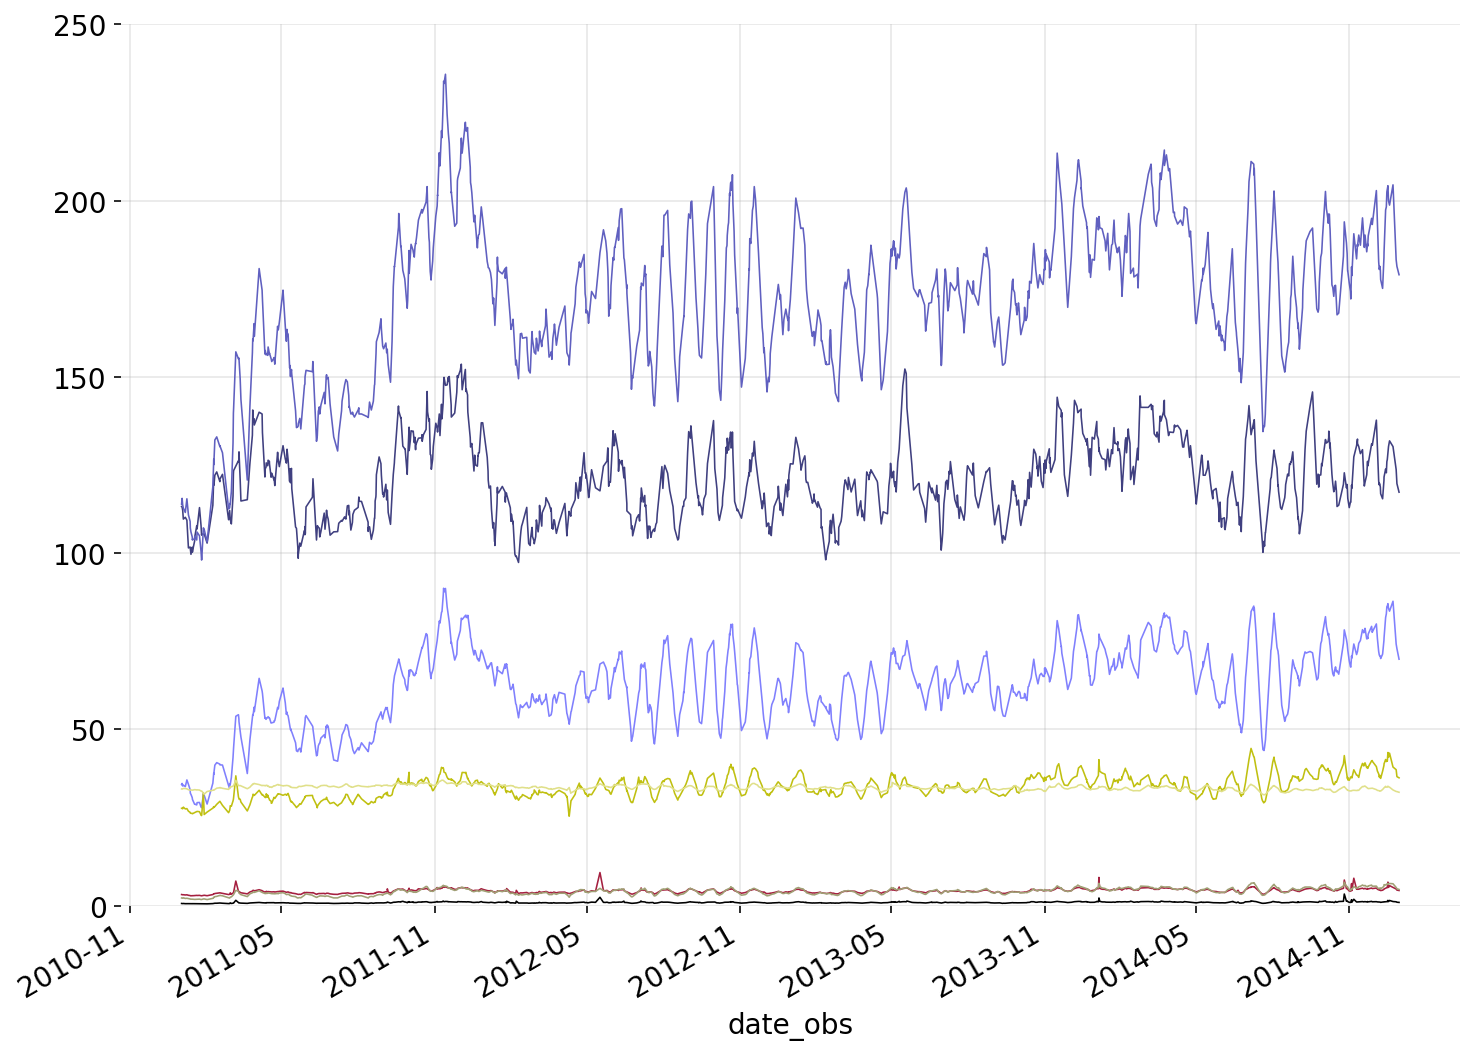

In [102]:
fig,ax=plt.subplots()
aia_means_total.sample(1000).plot(ax=ax,lw=0.8,legend=False)
ax.set_ylim(0,250);

## Make predictive training data set for various days

In [7]:
aia_total=pd.read_csv('{}/aia/aia_total.csv'.format(csv_path),index_col='date_obs')
aia_means_total=pd.read_csv('{}/aia/aia_means_total.csv'.format(csv_path),index_col='date_obs')
aia_eve_joined_total=pd.read_csv('{}/eve_aia_joined/aia_eve_total.csv'.format(csv_path),index_col='date_obs')

aia_total.index=pd.to_datetime(aia_total.index)
aia_means_total.index=pd.to_datetime(aia_means_total.index)
aia_eve_joined_total.index=pd.to_datetime(aia_eve_joined_total.index)

In [15]:
aia=aia_eve_joined_total.iloc[:,:9]

for hour in [192]:
    print(hour)
    eve=aia_eve_joined_total.iloc[:,9:]
    eve.reset_index(inplace=True)
    eve['date_obs']=eve.date_obs-pd.DateOffset(hours=hour)
    eve.set_index('date_obs',inplace=True)
    
    aia_eve_future=aia.join(eve).dropna()
    aia_eve_future.to_csv('{}/predictions/aia_eve_future_{}_hours.csv'.format(csv_path,hour))

192


## AIA means past data

In [54]:
aia_means=aia_means_total
aia_eve_joined=aia_eve_joined_total
eve=aia_eve_joined.iloc[:,9:]
aia_means_eve=aia_means.join(eve).dropna()
aia_means_eve.row_name=aia_means_eve.row_name.astype('int')
aia_means_eve.to_csv('{}/aia_means_eve.csv'.format(csv_path),index_label='date_obs')

In [8]:
aia_means_eve=pd.read_csv('{}/aia_means_eve.csv'.format(csv_path),index_col='date_obs')
aia_means_eve.index=pd.to_datetime(aia_means_eve.index)

In [ ]:
range()

In [6]:
204/24

8.5

In [9]:
aia=aia_means_eve.iloc[:,:9]

for hour in [72]:
    print(hour)
    eve=aia_means_eve.iloc[:,9:]
    eve.reset_index(inplace=True)
    eve['date_obs']=eve.date_obs-pd.DateOffset(hours=hour)
    eve.set_index('date_obs',inplace=True)
    
    aia_eve_future=aia.join(eve).dropna()
    aia_eve_future.to_csv('{}/predictions/aia_means_eve_future_{}_hours.csv'.format(csv_path,hour))

72


In [10]:
'{}/predictions/aia_means_eve_future_{}_hours.csv'.format(csv_path,hour)

'/scratch/data/csv_files/predictions/aia_means_eve_future_72_hours.csv'

In [11]:
cp /scratch/data/csv_files/predictions/aia_means_eve_future_72_hours.csv /home/richard/repos/sw2018-irradiance/production_csv_files/predictions